Six-Hump Camel synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/camel6.html

In [1]:
pip install pyGPGO


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 

In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
### Inputs:

obj_func = 'SixHumpCamel'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'SixHumpCamel':

    # True y bounds:
    operator = -1
    y_lb = -1.0316 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb_x1 = -3
    ub_x1 = +3
    lb_x2 = -2
    ub_x2 = +2

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 55
run_num_6 = 660
run_num_7 = 7
run_num_8 = 8
run_num_9 = 99
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 1004
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]

    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        #f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        f = (std + self.eps) * (norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx
        #df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df2 = (std + self.eps) * (-gamma * norm.pdf(gamma))
        df = df1 + df2
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t EI exact \t EI approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t EI exact \t EI approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.49786797  0.88129797]	 -0.26500829	 -0.26500829	     	     	     	     	    
init	 [-2.99931375 -0.79066971]	 110.13991869	 -0.26500829	     	     	     	     	    
init	 [-2.11946466 -1.63064562]	 26.90935479	 -0.26500829	     	     	     	     	    
init	 [-1.88243873 -0.61775709]	 2.85583631	 -0.26500829	     	     	     	     	    
init	 [-0.61939515  0.15526694]	 1.05405221	 -0.26500829	     	     	     	     	    
1  	 [0.6492576 2.       ]	 50.63647131	 -0.26500829	 26.6 	 0.7912318 	 0.79140382 	 1.0 	 4.858
2  	 [-1.76571864  1.31669539]	 4.92314891	 -0.26500829	 39.4 	 0.79248734 	 0.79345547 	 0.999 	 6.446
3  	 [ 2.44196256 -1.16522855]	 18.95789866	 -0.26500829	 23.8 	 0.79090749 	 0.79090987 	 1.0 	 6.973
4  	 [-0.59493686 -1.04964105]	 2.24035613	 -0.26500829	 21.2 	 0.78832443 	 0.79005415 	 0.998 	 4.485
5  	 [3.         1.27414179]	 116.77087086	 -0.26500829

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.38403059 -1.89629507]	 38.61280126	 0.01193961	     	     	     	     	    
init	 [ 0.29797487 -0.25871043]	 0.01193961	 0.01193961	     	     	     	     	    
init	 [-0.47779319 -0.67866072]	 0.13814534	 0.01193961	     	     	     	     	    
init	 [-1.7721082   0.47708387]	 0.62614476	 0.01193961	     	     	     	     	    
init	 [-1.20207196 -0.9326909 ]	 3.06938116	 0.01193961	     	     	     	     	    
1  	 [-2.90571363 -1.22389506]	 91.23921288	 0.01193961	 23.6 	 0.79787217 	 0.79787809 	 1.0 	 4.902
2  	 [ 1.78820843 -1.65292317]	 18.19111684	 0.01193961	 26.6 	 0.79788169 	 0.79788428 	 1.0 	 6.719
3  	 [2.93764341 0.12566665]	 92.66011192	 0.01193961	 28.0 	 0.79788441 	 0.79788437 	 1.0 	 7.929
4  	 [0.34124433 2.        ]	 49.12032965	 0.01193961	 17.8 	 0.79154929 	 0.79769045 	 0.992 	 4.854
5  	 [-3.  2.]	 150.9	 0.01193961	 12.8 	 0.74642156 	 0.79701225 

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.30478742 0.83259129]	 -0.24319229	 -0.24319229	     	     	     	     	    
init	 [-1.25457157  0.04331042]	 2.33133105	 -0.24319229	     	     	     	     	    
init	 [2.35768173 1.58517236]	 33.54152175	 -0.24319229	     	     	     	     	    
init	 [-2.24648814 -1.17102849]	 14.21410941	 -0.24319229	     	     	     	     	    
init	 [-2.69119678 -0.23676063]	 45.87579772	 -0.24319229	     	     	     	     	    
1  	 [ 0.30378627 -1.04928878]	 0.47759911	 -0.24319229	 29.7 	 0.79256843 	 0.79463724 	 0.997 	 5.534
2  	 [-0.89575637  2.        ]	 48.2381923	 -0.24319229	 21.6 	 0.79182549 	 0.79230578 	 0.999 	 7.065
3  	 [ 3. -2.]	 150.9	 -0.24319229	 21.0 	 0.76790334 	 0.79197022 	 0.97 	 7.128
4  	 [-0.45133463 -2.        ]	 49.63315934	 -0.24319229	 22.5 	 0.75618097 	 0.76967284 	 0.982 	 4.232
5  	 [ 1.28248541 -0.21891728]	 1.91792792	 -0.24319229	 35.7 	 0.7658137

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [2.80217903 0.188929  ]	 63.70212733	 2.31964022	     	     	     	     	    
init	 [2.83610616 0.85926397]	 71.43837111	 2.31964022	     	     	     	     	    
init	 [ 1.18637295 -1.13564202]	 2.54632678	 2.31964022	     	     	     	     	    
init	 [ 2.85764673 -1.97507898]	 113.76785286	 2.31964022	     	     	     	     	    
init	 [-1.48210583 -0.26083387]	 2.31964022	 2.31964022	     	     	     	     	    
1  	 [0.74130267 1.88900012]	 39.67797825	 2.31964022	 59.6 	 0.77090655 	 0.79744097 	 0.967 	 5.534
2  	 [-1.31904814  2.        ]	 47.71998313	 2.31964022	 45.2 	 0.61993903 	 0.79588673 	 0.779 	 8.586
3  	 [-3.          0.66119596]	 105.93219749	 2.31964022	 20.2 	 0.75393456 	 0.79276505 	 0.951 	 2.411
4  	 [-3.         -1.75433419]	 139.74091364	 2.31964022	 15.3 	 0.67560976 	 0.79661898 	 0.848 	 2.731
5  	 [-0.63371088 -2.        ]	 50.55669269	 2.31964022	 

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.44135028  1.88662368]	 51.64954283	 -0.80071988	     	     	     	     	    
init	 [-0.09684012 -1.02990919]	 0.39466019	 -0.80071988	     	     	     	     	    
init	 [ 0.18674298 -0.85782306]	 -0.80071988	 -0.80071988	     	     	     	     	    
init	 [ 2.17578226 -1.83559939]	 35.17830829	 -0.80071988	     	     	     	     	    
init	 [-2.3499136   1.06864018]	 12.31874569	 -0.80071988	     	     	     	     	    
1  	 [0.4843767  0.28650341]	 0.66457971	 -0.80071988	 47.2 	 0.74106238 	 0.74358229 	 0.997 	 7.96
2  	 [-3. -2.]	 162.9	 -0.80071988	 30.8 	 0.73643188 	 0.73643194 	 1.0 	 12.727
3  	 [3. 2.]	 162.9	 -0.80071988	 29.4 	 0.73643188 	 0.73643188 	 1.0 	 6.425
4  	 [-0.931144   -0.09364388]	 2.15915041	 -0.80071988	 28.8 	 0.70461491 	 0.72104942 	 0.977 	 4.789
5  	 [0.17041672 2.        ]	 48.45523782	 -0.80071988	 22.0 	 0.72976314 	 0.72980147 	 1.0 	 4.9

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.17097775 -0.59014471]	 0.79681346	 0.47174388	     	     	     	     	    
init	 [-2.77340474  0.79455008]	 55.07980652	 0.47174388	     	     	     	     	    
init	 [2.02046143 1.40318168]	 14.47558754	 0.47174388	     	     	     	     	    
init	 [ 0.97192502 -0.76993343]	 0.47174388	 0.47174388	     	     	     	     	    
init	 [2.62189686 0.20289758]	 36.91862563	 0.47174388	     	     	     	     	    
1  	 [-2.21470835 -2.        ]	 60.8614708	 0.47174388	 48.0 	 0.79785406 	 0.79785406 	 1.0 	 7.516
2  	 [-0.08975149  2.        ]	 47.85258224	 0.47174388	 21.8 	 0.78927542 	 0.78933986 	 1.0 	 3.634
3  	 [ 1.90774274 -2.        ]	 46.99552086	 0.47174388	 16.0 	 0.75363669 	 0.78566657 	 0.959 	 4.244
4	 [-0.14959848 -0.50366348]	 -0.59348165	 -0.59348165	 20.7 	 0.76571241 	 0.765723 	 1.0 	 2.447
5  	 [ 0.21901825 -0.29429615]	 -0.19381118	 -0.59348165	 14.4 	 0.6

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.54215026  1.11967517]	 26.53843864	 -0.46481073	     	     	     	     	    
init	 [-0.36954461  0.89386071]	 -0.46481073	 -0.46481073	     	     	     	     	    
init	 [2.86793707 0.15398348]	 76.66051065	 -0.46481073	     	     	     	     	    
init	 [ 0.00672278 -1.71179547]	 22.61301089	 -0.46481073	     	     	     	     	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.29458553	 -0.46481073	     	     	     	     	    
1  	 [0.38874179 2.        ]	 49.33515633	 -0.46481073	 38.8 	 0.77002093 	 0.77539873 	 0.993 	 8.777
2  	 [-2.0069916  -0.34039291]	 4.09787809	 -0.46481073	 3.0 	 0.77662516 	 0.77662516 	 1.0 	 0.0
3  	 [0.11301486 0.12078085]	 0.00689677	 -0.46481073	 29.4 	 0.77608671 	 0.7787231 	 0.997 	 7.525
4  	 [-3. -2.]	 162.9	 -0.46481073	 32.7 	 0.76969436 	 0.77642725 	 0.991 	 5.846
5  	 [ 2.23969559 -2.        ]	 52.81793212	 -0.46481073	 27.4 	 0.73131

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [2.24057642 1.87416265]	 48.82879578	 0.03190065	     	     	     	     	    
init	 [2.21516724 0.12342277]	 8.66062355	 0.03190065	     	     	     	     	    
init	 [-1.60363003 -1.95440478]	 48.28332374	 0.03190065	     	     	     	     	    
init	 [-0.41718709 -0.39059456]	 0.2801229	 0.03190065	     	     	     	     	    
init	 [ 0.13604803 -0.08643282]	 0.03190065	 0.03190065	     	     	     	     	    
1  	 [-3.          1.30612774]	 109.79906809	 0.03190065	 32.0 	 0.79744252 	 0.79787716 	 0.999 	 9.635
2  	 [ 3. -2.]	 150.9	 0.03190065	 19.0 	 0.73467488 	 0.79604655 	 0.923 	 5.939
3	 [-0.1442385   0.70386928]	 -1.01912856	 -1.01912856	 16.6 	 0.72807791 	 0.72859491 	 0.999 	 2.282
4  	 [-0.05431769  0.35472534]	 -0.44747193	 -1.01912856	 10.4 	 0.61411107 	 0.6189909 	 0.992 	 1.784
5  	 [-0.03622461  0.3030795 ]	 -0.33941144	 -1.01912856	 17.1 	 0.59379265 	 0.59

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.03367135 -0.0476864 ]	 2.22469625	 2.22469625	     	     	     	     	    
init	 [ 1.95297104 -1.87421445]	 34.84663504	 2.22469625	     	     	     	     	    
init	 [1.84829978 0.26246968]	 2.67497273	 2.22469625	     	     	     	     	    
init	 [-1.21426501 -1.81321712]	 34.68894768	 2.22469625	     	     	     	     	    
init	 [ 2.9437644  -1.97269707]	 133.08463965	 2.22469625	     	     	     	     	    
1  	 [-1.75937129 -0.10901173]	 2.29145587	 2.22469625	 55.2 	 0.79624808 	 0.796249 	 1.0 	 6.009
2  	 [-2.99372422 -2.        ]	 161.12175224	 2.22469625	 60.9 	 0.79606051 	 0.79616092 	 1.0 	 8.055
3  	 [-3.         0.5364707]	 106.47070187	 2.22469625	 38.8 	 0.78223632 	 0.78348934 	 0.998 	 6.93
4  	 [-1.15735411  2.        ]	 48.07647715	 2.22469625	 32.4 	 0.77424371 	 0.79683641 	 0.972 	 3.621
5  	 [1.00380451 2.        ]	 52.24697738	 2.22469625	 23.8 	 0

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.62792386 -1.9169922 ]	 38.25414771	 0.77756875	     	     	     	     	    
init	 [0.80188941 0.99521553]	 2.55265171	 0.77756875	     	     	     	     	    
init	 [-0.00895793 -1.10081342]	 1.03676302	 0.77756875	     	     	     	     	    
init	 [-1.81162281  1.04212285]	 0.77756875	 0.77756875	     	     	     	     	    
init	 [-1.98533498 -1.64664074]	 25.38348144	 0.77756875	     	     	     	     	    
1  	 [ 2.78955918 -0.47567758]	 59.00572691	 0.77756875	 60.2 	 0.79771856 	 0.79772086 	 1.0 	 4.541
2  	 [-3.          0.51235288]	 106.58855594	 0.77756875	 26.8 	 0.77864426 	 0.77867872 	 1.0 	 3.999
3  	 [2.76002492 1.08669558]	 59.81420051	 0.77756875	 65.6 	 0.79781518 	 0.79781479 	 1.0 	 6.349
4  	 [-0.81262446  0.07399372]	 1.73975874	 0.77756875	 28.0 	 0.76207091 	 0.76667076 	 0.994 	 4.497
5  	 [0.59563081 2.        ]	 50.36093189	 0.77756875	 21.6 	 0.7

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.91838187 -1.92209903]	 46.39910375	 -0.62546883	     	     	     	     	    
init	 [-0.22068884  0.89973572]	 -0.62546883	 -0.62546883	     	     	     	     	    
init	 [-0.47877837 -0.05829161]	 0.82494702	 -0.62546883	     	     	     	     	    
init	 [-2.92331511 -0.05051357]	 88.99028404	 -0.62546883	     	     	     	     	    
init	 [2.65083991 1.40318036]	 51.4234254	 -0.62546883	     	     	     	     	    
1  	 [ 1.7922134 -2.       ]	 46.64402271	 -0.62546883	 21.4 	 0.74413562 	 0.75224151 	 0.989 	 6.478
2  	 [-0.44496996  2.        ]	 47.82231358	 -0.62546883	 26.1 	 0.68963739 	 0.7302122 	 0.944 	 6.943
3  	 [ 0.20970569 -0.0253281 ]	 0.16399715	 -0.62546883	 10.0 	 0.70172268 	 0.70617281 	 0.994 	 1.461
4  	 [ 0.1212949  -0.01092781]	 0.05659321	 -0.62546883	 20.6 	 0.2472843 	 0.63822374 	 0.387 	 3.176
5  	 [ 0.09594816 -0.00401231]	 0.03619711	 -0.625468

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.07502295  0.96019879]	 2.61858572	 1.99677359	     	     	     	     	    
init	 [-1.42010991  0.13495757]	 1.99677359	 1.99677359	     	     	     	     	    
init	 [-2.91255023  1.67498803]	 101.67816714	 1.99677359	     	     	     	     	    
init	 [ 2.40428912 -1.86631429]	 47.44624884	 1.99677359	     	     	     	     	    
init	 [ 2.74169602 -1.45116271]	 58.32400186	 1.99677359	     	     	     	     	    
1	 [ 1.48256102 -0.53421023]	 0.57838561	 0.57838561	 51.0 	 0.79735665 	 0.7975076 	 1.0 	 4.688
2  	 [3.        0.2929357]	 109.46501614	 0.57838561	 42.3 	 0.79775375 	 0.7977538 	 1.0 	 5.658
3  	 [0.82968179 2.        ]	 51.52648351	 0.57838561	 41.6 	 0.79514845 	 0.79780251 	 0.997 	 6.261
4  	 [-3.         -0.96352412]	 111.52460569	 0.57838561	 21.9 	 0.77053856 	 0.79502335 	 0.969 	 7.583
5  	 [-0.32647289 -2.        ]	 49.05583102	 0.57838561	 17.6 	 0.

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.66621446 -1.04983512]	 0.75293092	 0.75293092	     	     	     	     	    
init	 [1.9456712  1.86299679]	 41.05776363	 0.75293092	     	     	     	     	    
init	 [ 2.83560668 -0.18620301]	 69.01345447	 0.75293092	     	     	     	     	    
init	 [0.65425478 1.10210606]	 3.11745217	 0.75293092	     	     	     	     	    
init	 [0.84968007 0.88807292]	 2.00660153	 0.75293092	     	     	     	     	    
1  	 [ 1.88640902 -2.        ]	 46.88944845	 0.75293092	 31.6 	 0.74328644 	 0.75826106 	 0.98 	 10.227
2  	 [ 2.75360839 -0.18704267]	 54.2545546	 0.75293092	 3.0 	 0.74330081 	 0.74330081 	 1.0 	 0.0
3  	 [-0.40900378 -2.        ]	 49.42993802	 0.75293092	 21.6 	 0.79289275 	 0.79704367 	 0.995 	 8.35
4  	 [-2.71821    -0.72706034]	 50.34518917	 0.75293092	 27.8 	 0.79682135 	 0.79778884 	 0.999 	 8.209
5  	 [-2.6705531  1.9148086]	 76.62412426	 0.75293092	 15.6 	 0.7964

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.76629017  1.42598344]	 61.46785297	 1.17102482	     	     	     	     	    
init	 [1.47900185 1.45571157]	 13.82925976	 1.17102482	     	     	     	     	    
init	 [ 0.35990643 -1.67806771]	 20.3334516	 1.17102482	     	     	     	     	    
init	 [-1.61018221 -1.03094392]	 3.99105058	 1.17102482	     	     	     	     	    
init	 [0.69300008 0.42843637]	 1.17102482	 1.17102482	     	     	     	     	    
1  	 [ 2.37036857 -2.        ]	 58.56393096	 1.17102482	 43.0 	 0.79480461 	 0.79655266 	 0.998 	 5.558
2  	 [-3.         -1.31013373]	 117.7494075	 1.17102482	 25.2 	 0.7337918 	 0.78429579 	 0.936 	 4.865
3  	 [-1.07651651  1.67259451]	 20.6487906	 1.17102482	 56.1 	 0.79773866 	 0.79773805 	 1.0 	 8.328
4  	 [-0.62495716 -0.08735146]	 1.28610182	 1.17102482	 28.5 	 0.74488181 	 0.76340773 	 0.976 	 6.649
5  	 [3. 2.]	 162.9	 1.17102482	 38.1 	 0.73725718 	 0.73725718 

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.09290618 -1.2844163 ]	 6.84252101	 2.11631708	     	     	     	     	    
init	 [-2.67382071 -0.55384622]	 43.69785231	 2.11631708	     	     	     	     	    
init	 [-1.34759443  0.1200009 ]	 2.11631708	 2.11631708	     	     	     	     	    
init	 [-1.16448651 -0.78210256]	 2.35440873	 2.11631708	     	     	     	     	    
init	 [-2.32955234 -1.00040394]	 15.46911925	 2.11631708	     	     	     	     	    
1  	 [-3.          0.91242851]	 105.60500807	 2.11631708	 53.6 	 0.7948518 	 0.79682696 	 0.998 	 9.267
2  	 [-0.869734  2.      ]	 48.22894374	 2.11631708	 35.2 	 0.76197023 	 0.79522455 	 0.958 	 9.646
3  	 [1.28644838 1.66378041]	 24.09774916	 2.11631708	 36.0 	 0.7970328 	 0.79701531 	 1.0 	 6.517
4  	 [3.         0.89390333]	 110.93946509	 2.11631708	 24.2 	 0.79436625 	 0.79455471 	 1.0 	 4.433
5	 [ 0.56218512 -0.26299578]	 0.65958177	 0.65958177	 16.4 	 0.7646

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.66025353  0.09265337]	 1.86327737	 1.86327737	     	     	     	     	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424	 1.86327737	     	     	     	     	    
init	 [-0.83562699 -1.10767623]	 3.92206128	 1.86327737	     	     	     	     	    
init	 [ 1.13235697 -1.3450743 ]	 6.71216715	 1.86327737	     	     	     	     	    
init	 [-2.5780508   1.76404344]	 53.42443471	 1.86327737	     	     	     	     	    
1  	 [-0.76583439  2.        ]	 48.15922137	 1.86327737	 51.0 	 0.79732897 	 0.79732898 	 1.0 	 6.956
2  	 [1.45528193 2.        ]	 53.1292491	 1.86327737	 46.8 	 0.79653419 	 0.79715634 	 0.999 	 5.902
3  	 [3.         0.31623137]	 109.48868682	 1.86327737	 38.1 	 0.77013576 	 0.79713864 	 0.966 	 6.668
4  	 [-3.         -0.31594174]	 109.48840397	 1.86327737	 21.2 	 0.56125834 	 0.78309397 	 0.717 	 4.362
5	 [-0.32006479  0.01176703]	 0.3837663	 0.3837663	 18.8 	 0

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.23200998  0.12234702]	 2.18920665	 1.77227688	     	     	     	     	    
init	 [-1.85087528 -1.72839857]	 29.40606782	 1.77227688	     	     	     	     	    
init	 [1.72191276 0.62533409]	 2.21134014	 1.77227688	     	     	     	     	    
init	 [0.82512538 0.30241158]	 1.77227688	 1.77227688	     	     	     	     	    
init	 [-2.7656225  -0.56874558]	 57.5922316	 1.77227688	     	     	     	     	    
1  	 [-3.         1.7227444]	 127.09286701	 1.77227688	 30.4 	 0.79659475 	 0.79711945 	 0.999 	 4.31
2  	 [-0.41842194  2.        ]	 47.80088356	 1.77227688	 45.8 	 0.79519076 	 0.79520446 	 1.0 	 6.953
3  	 [ 0.00682946 -2.        ]	 47.98652764	 1.77227688	 36.2 	 0.79447941 	 0.79448191 	 1.0 	 6.677
4  	 [ 2.27840597 -2.        ]	 54.24719545	 1.77227688	 34.5 	 0.79721093 	 0.79721095 	 1.0 	 4.982
5  	 [1.87244966 2.        ]	 54.32102261	 1.77227688	 31.2 	 0.7822

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.90224545 0.02181349]	 2.06216977	 2.06216977	     	     	     	     	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291	 2.06216977	     	     	     	     	    
init	 [2.11339841 1.00054514]	 7.79212876	 2.06216977	     	     	     	     	    
init	 [0.99661    1.95158179]	 46.96206223	 2.06216977	     	     	     	     	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528	 2.06216977	     	     	     	     	    
1  	 [-1.04020125  1.98447453]	 46.51068265	 2.06216977	 40.6 	 0.79690022 	 0.79709233 	 1.0 	 4.355
2  	 [-2.74619913  0.22548017]	 52.89341197	 2.06216977	 45.9 	 0.76379438 	 0.79741786 	 0.958 	 5.193
3  	 [3.         0.13506858]	 109.23356295	 2.06216977	 31.4 	 0.76737317 	 0.76801751 	 0.999 	 4.529
4	 [-0.7323195  -0.07619293]	 1.62531365	 1.62531365	 32.7 	 0.79469935 	 0.7966724 	 0.998 	 3.885
5  	 [ 0.25207943 -2.        ]	 47.74162335	 1.62531365	 31.2 	 0.78

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.41479839  1.04499887]	 15.89047544	 6.57808885	     	     	     	     	    
init	 [-1.51837216 -1.44747325]	 13.52083951	 6.57808885	     	     	     	     	    
init	 [-1.01132062 -1.66800174]	 23.77215857	 6.57808885	     	     	     	     	    
init	 [1.03186249 1.22637519]	 6.57808885	 6.57808885	     	     	     	     	    
init	 [2.89645149 0.54264294]	 83.31828504	 6.57808885	     	     	     	     	    
1	 [ 1.99532209 -1.16565465]	 3.2981427	 3.2981427	 63.2 	 0.7888719 	 0.79541002 	 0.992 	 4.062
2	 [-0.68576894  0.16873006]	 1.22499746	 1.22499746	 47.0 	 0.79076934 	 0.79078337 	 1.0 	 4.132
3  	 [-0.85186885  2.        ]	 48.22048282	 1.22499746	 29.6 	 0.79111909 	 0.79241569 	 0.998 	 8.209
4  	 [ 0.88738651 -2.        ]	 48.23563056	 1.22499746	 20.8 	 0.78323675 	 0.78323675 	 1.0 	 3.325
5  	 [-3. -2.]	 162.9	 1.22499746	 20.1 	 0.73371288 	 0.77913328 	 0.

In [33]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.52878481 1.59085491]	 17.29968374	 1.50373928	     	     	     	     	    
init	 [2.34918438 1.26334991]	 20.9158305	 1.50373928	     	     	     	     	    
init	 [-2.78466249  0.76703033]	 57.06253405	 1.50373928	     	     	     	     	    
init	 [-0.72791435  0.07404378]	 1.50373928	 1.50373928	     	     	     	     	    
init	 [ 0.94770879 -1.22459913]	 3.97667377	 1.50373928	     	     	     	     	    
1  	 [-3.         -1.64491858]	 132.29621373	 1.50373928	 42.6 	 0.72447222 	 0.79757898 	 0.908 	 8.431
2  	 [ 3.         -0.64878834]	 105.97864558	 1.50373928	 31.2 	 0.78772764 	 0.79513329 	 0.991 	 5.479
3  	 [-0.35082756 -2.        ]	 49.1627843	 1.50373928	 15.4 	 0.78159323 	 0.78667401 	 0.994 	 3.209
4	 [-0.11953797  0.16493068]	 -0.06883468	 -0.06883468	 15.9 	 0.53886398 	 0.5792727 	 0.93 	 2.656
5	 [-0.09728601  0.15731894]	 -0.07418138	 -0.07418138	 17.6 

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.49786797  0.88129797]	 -0.26500829	 -0.26500829	     	     	     	     	    
init	 [-2.99931375 -0.79066971]	 110.13991869	 -0.26500829	     	     	     	     	    
init	 [-2.11946466 -1.63064562]	 26.90935479	 -0.26500829	     	     	     	     	    
init	 [-1.88243873 -0.61775709]	 2.85583631	 -0.26500829	     	     	     	     	    
init	 [-0.61939515  0.15526694]	 1.05405221	 -0.26500829	     	     	     	     	    
1  	 [1.07291996 1.54022156]	 17.00457768	 -0.26500829	 23.4 	 0.7912318 	 0.79140382 	 1.0 	 7.492
2  	 [-1.60325142  1.9260717 ]	 39.18988859	 -0.26500829	 19.3 	 0.79190465 	 0.79194408 	 1.0 	 4.987
3  	 [ 1.9738854  -1.37283442]	 7.38081272	 -0.26500829	 15.6 	 0.79089036 	 0.79091 	 1.0 	 0.86
4  	 [3.         0.70516958]	 110.01553869	 -0.26500829	 15.0 	 0.78603909 	 0.79002414 	 0.995 	 6.182
5  	 [-0.86496901 -1.0517901 ]	 3.33676988	 -0.26500829	 15

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-0.38403059 -1.89629507]	 38.61280126	 0.01193961	     	     	     	     	    
init	 [ 0.29797487 -0.25871043]	 0.01193961	 0.01193961	     	     	     	     	    
init	 [-0.47779319 -0.67866072]	 0.13814534	 0.01193961	     	     	     	     	    
init	 [-1.7721082   0.47708387]	 0.62614476	 0.01193961	     	     	     	     	    
init	 [-1.20207196 -0.9326909 ]	 3.06938116	 0.01193961	     	     	     	     	    
1  	 [-2.8367858  -1.01129104]	 72.87061667	 0.01193961	 18.5 	 0.79787217 	 0.79787809 	 1.0 	 2.513
2  	 [ 1.73459227 -1.39763985]	 7.12871217	 0.01193961	 19.6 	 0.79788178 	 0.79788431 	 1.0 	 3.243
3  	 [2.63491252 0.30511148]	 38.56478779	 0.01193961	 12.2 	 0.79788346 	 0.79788353 	 1.0 	 5.321
4  	 [0.41484319 1.22052616]	 4.05210902	 0.01193961	 14.4 	 0.79768634 	 0.79788446 	 1.0 	 6.161
5  	 [-1.18463303  2.        ]	 48.02966118	 0.01193961	 22.3 	 0.7977

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.30478742 0.83259129]	 -0.24319229	 -0.24319229	     	     	     	     	    
init	 [-1.25457157  0.04331042]	 2.33133105	 -0.24319229	     	     	     	     	    
init	 [2.35768173 1.58517236]	 33.54152175	 -0.24319229	     	     	     	     	    
init	 [-2.24648814 -1.17102849]	 14.21410941	 -0.24319229	     	     	     	     	    
init	 [-2.69119678 -0.23676063]	 45.87579772	 -0.24319229	     	     	     	     	    
1	 [ 0.04379337 -0.8622977 ]	 -0.79281852	 -0.79281852	 18.0 	 0.79256843 	 0.79463724 	 0.997 	 2.439
2  	 [-0.73350745  2.        ]	 48.12912701	 -0.79281852	 24.3 	 0.74543383 	 0.74773345 	 0.997 	 3.643
3  	 [0.87515745 0.12837425]	 2.0290088	 -0.79281852	 13.8 	 0.75076331 	 0.7630416 	 0.984 	 2.461
4  	 [ 1.97400647 -1.70384881]	 22.15884988	 -0.79281852	 20.6 	 0.73475686 	 0.74287731 	 0.989 	 3.276
5  	 [-0.1374502   0.00226222]	 0.07449151	 -0.79281852

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [2.80217903 0.188929  ]	 63.70212733	 2.31964022	     	     	     	     	    
init	 [2.83610616 0.85926397]	 71.43837111	 2.31964022	     	     	     	     	    
init	 [ 1.18637295 -1.13564202]	 2.54632678	 2.31964022	     	     	     	     	    
init	 [ 2.85764673 -1.97507898]	 113.76785286	 2.31964022	     	     	     	     	    
init	 [-1.48210583 -0.26083387]	 2.31964022	 2.31964022	     	     	     	     	    
1  	 [0.43283262 1.3817746 ]	 8.22045747	 2.31964022	 30.3 	 0.77090655 	 0.79744097 	 0.967 	 5.073
2  	 [-0.56676725  1.52871597]	 12.71070515	 2.31964022	 20.7 	 0.75630099 	 0.76427774 	 0.99 	 1.663
3  	 [-2.19148436  0.96017892]	 5.30586009	 2.31964022	 10.0 	 0.73643221 	 0.78358691 	 0.94 	 3.396
4	 [-1.78340971  0.04554913]	 2.11400607	 2.11400607	 13.4 	 0.68414567 	 0.76489717 	 0.894 	 2.007
5	 [-0.43107011  0.02322828]	 0.6607423	 0.6607423	 16.1 	 0.74975

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.44135028  1.88662368]	 51.64954283	 -0.80071988	     	     	     	     	    
init	 [-0.09684012 -1.02990919]	 0.39466019	 -0.80071988	     	     	     	     	    
init	 [ 0.18674298 -0.85782306]	 -0.80071988	 -0.80071988	     	     	     	     	    
init	 [ 2.17578226 -1.83559939]	 35.17830829	 -0.80071988	     	     	     	     	    
init	 [-2.3499136   1.06864018]	 12.31874569	 -0.80071988	     	     	     	     	    
1  	 [0.81415769 0.46153653]	 1.53100898	 -0.80071988	 22.4 	 0.74106238 	 0.74358229 	 0.997 	 8.554
2  	 [3. 2.]	 162.9	 -0.80071988	 11.0 	 0.73638784 	 0.73643192 	 1.0 	 11.223
3  	 [-2.66254093 -1.77744371]	 73.59597508	 -0.80071988	 17.3 	 0.7364096 	 0.73643188 	 1.0 	 0.86
4  	 [-0.43798591 -0.14233231]	 0.67534825	 -0.80071988	 18.8 	 0.71070899 	 0.7220332 	 0.984 	 2.063
5  	 [0.14113872 2.        ]	 48.36112732	 -0.80071988	 28.1 	 0.72613988 	 0.

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.17097775 -0.59014471]	 0.79681346	 0.47174388	     	     	     	     	    
init	 [-2.77340474  0.79455008]	 55.07980652	 0.47174388	     	     	     	     	    
init	 [2.02046143 1.40318168]	 14.47558754	 0.47174388	     	     	     	     	    
init	 [ 0.97192502 -0.76993343]	 0.47174388	 0.47174388	     	     	     	     	    
init	 [2.62189686 0.20289758]	 36.91862563	 0.47174388	     	     	     	     	    
1  	 [-2.21491503 -2.        ]	 60.86871416	 0.47174388	 14.9 	 0.79785406 	 0.79785406 	 1.0 	 2.712
2  	 [-0.06608084  2.        ]	 47.88526502	 0.47174388	 15.4 	 0.78927546 	 0.78933991 	 1.0 	 4.697
3  	 [ 0.15851302 -1.35484465]	 6.01977692	 0.47174388	 9.4 	 0.75332751 	 0.78567905 	 0.959 	 0.408
4  	 [ 1.93072319 -1.93616913]	 40.47542811	 0.47174388	 9.4 	 0.76639363 	 0.77886297 	 0.984 	 1.627
5	 [ 0.20422336 -0.20130325]	 -0.03343439	 -0.03343439	 7.2 	 0.6

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.54215026  1.11967517]	 26.53843864	 -0.46481073	     	     	     	     	    
init	 [-0.36954461  0.89386071]	 -0.46481073	 -0.46481073	     	     	     	     	    
init	 [2.86793707 0.15398348]	 76.66051065	 -0.46481073	     	     	     	     	    
init	 [ 0.00672278 -1.71179547]	 22.61301089	 -0.46481073	     	     	     	     	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.29458553	 -0.46481073	     	     	     	     	    
1  	 [-2.99143872 -1.63095062]	 129.03830114	 -0.46481073	 27.6 	 0.77002093 	 0.77539873 	 0.993 	 6.42
2  	 [0.58912244 2.        ]	 50.32748705	 -0.46481073	 10.3 	 0.71727148 	 0.74625617 	 0.961 	 3.504
3  	 [-0.86165708  0.51158307]	 0.73494325	 -0.46481073	 7.2 	 0.5291072 	 0.63972705 	 0.827 	 0.23
4  	 [-0.4522468   0.37454932]	 0.08129919	 -0.46481073	 8.2 	 0.51847829 	 0.60865708 	 0.852 	 0.722
5  	 [-1.03623812  1.55595439]	 14.43504285	 -

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [2.24057642 1.87416265]	 48.82879578	 0.03190065	     	     	     	     	    
init	 [2.21516724 0.12342277]	 8.66062355	 0.03190065	     	     	     	     	    
init	 [-1.60363003 -1.95440478]	 48.28332374	 0.03190065	     	     	     	     	    
init	 [-0.41718709 -0.39059456]	 0.2801229	 0.03190065	     	     	     	     	    
init	 [ 0.13604803 -0.08643282]	 0.03190065	 0.03190065	     	     	     	     	    
1  	 [-2.11077779  1.21153517]	 5.80544757	 0.03190065	 27.0 	 0.79744252 	 0.79787716 	 0.999 	 3.58
2  	 [ 0.85480628 -0.91637864]	 0.60999288	 0.03190065	 27.0 	 0.73047457 	 0.79604618 	 0.918 	 5.389
3	 [-0.24548942  0.66024417]	 -0.91215295	 -0.91215295	 15.3 	 0.7262647 	 0.79577573 	 0.913 	 3.094
4  	 [-0.22978361  0.43981725]	 -0.5197482	 -0.91215295	 17.0 	 0.61688962 	 0.6931098 	 0.89 	 3.739
5  	 [ 2.79426261 -1.42148898]	 66.15116189	 -0.91215295	 22.2 	 0.

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.03367135 -0.0476864 ]	 2.22469625	 2.22469625	     	     	     	     	    
init	 [ 1.95297104 -1.87421445]	 34.84663504	 2.22469625	     	     	     	     	    
init	 [1.84829978 0.26246968]	 2.67497273	 2.22469625	     	     	     	     	    
init	 [-1.21426501 -1.81321712]	 34.68894768	 2.22469625	     	     	     	     	    
init	 [ 2.9437644  -1.97269707]	 133.08463965	 2.22469625	     	     	     	     	    
1  	 [-1.73551234 -0.10206477]	 2.24083135	 2.22469625	 12.5 	 0.79624808 	 0.796249 	 1.0 	 12.862
2  	 [-3. -2.]	 162.9	 2.22469625	 14.4 	 0.79605275 	 0.7961715 	 1.0 	 12.755
3  	 [-2.9723883   0.54140289]	 98.86444243	 2.22469625	 22.4 	 0.78330603 	 0.78442985 	 0.999 	 5.517
4	 [-1.06139993  0.92096814]	 0.82505135	 0.82505135	 19.1 	 0.77332385 	 0.79674884 	 0.971 	 3.435
5  	 [3.         0.99822528]	 111.88054099	 0.82505135	 20.2 	 0.78144995 	 0.78152106

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.62792386 -1.9169922 ]	 38.25414771	 0.77756875	     	     	     	     	    
init	 [0.80188941 0.99521553]	 2.55265171	 0.77756875	     	     	     	     	    
init	 [-0.00895793 -1.10081342]	 1.03676302	 0.77756875	     	     	     	     	    
init	 [-1.81162281  1.04212285]	 0.77756875	 0.77756875	     	     	     	     	    
init	 [-1.98533498 -1.64664074]	 25.38348144	 0.77756875	     	     	     	     	    
1  	 [ 2.63819105 -0.36338128]	 37.08125026	 0.77756875	 26.7 	 0.79771856 	 0.79772086 	 1.0 	 3.61
2  	 [3. 2.]	 162.9	 0.77756875	 19.0 	 0.79192901 	 0.79192901 	 1.0 	 9.343
3  	 [-0.97469257  0.23016326]	 1.76555156	 0.77756875	 11.2 	 0.76253515 	 0.77852115 	 0.979 	 2.307
4  	 [-3.          0.52020395]	 106.54986329	 0.77756875	 18.8 	 0.77841443 	 0.77842349 	 1.0 	 3.06
5  	 [-1.33608834  1.22948101]	 3.79552399	 0.77756875	 10.0 	 0.69822044 	 0.7685187 	 0

In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.91838187 -1.92209903]	 46.39910375	 -0.62546883	     	     	     	     	    
init	 [-0.22068884  0.89973572]	 -0.62546883	 -0.62546883	     	     	     	     	    
init	 [-0.47877837 -0.05829161]	 0.82494702	 -0.62546883	     	     	     	     	    
init	 [-2.92331511 -0.05051357]	 88.99028404	 -0.62546883	     	     	     	     	    
init	 [2.65083991 1.40318036]	 51.4234254	 -0.62546883	     	     	     	     	    
1  	 [ 1.77861452 -1.74525428]	 24.01344108	 -0.62546883	 17.0 	 0.74413562 	 0.75224151 	 0.989 	 1.738
2  	 [-0.18983006  1.54196301]	 12.95099624	 -0.62546883	 14.8 	 0.68936704 	 0.73040766 	 0.944 	 3.358
3  	 [0.12944095 0.02189267]	 0.06734944	 -0.62546883	 8.6 	 0.53946628 	 0.54371166 	 0.992 	 1.938
4  	 [0.62235928 0.39860042]	 0.96715871	 -0.62546883	 10.8 	 0.1535466 	 0.53586541 	 0.287 	 1.315
5  	 [0.05973655 0.03310226]	 0.01184627	 -0.62546883	 

In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.07502295  0.96019879]	 2.61858572	 1.99677359	     	     	     	     	    
init	 [-1.42010991  0.13495757]	 1.99677359	 1.99677359	     	     	     	     	    
init	 [-2.91255023  1.67498803]	 101.67816714	 1.99677359	     	     	     	     	    
init	 [ 2.40428912 -1.86631429]	 47.44624884	 1.99677359	     	     	     	     	    
init	 [ 2.74169602 -1.45116271]	 58.32400186	 1.99677359	     	     	     	     	    
1  	 [ 2.2866235  -0.03687082]	 11.06169759	 1.99677359	 27.8 	 0.79735665 	 0.7975076 	 1.0 	 6.129
2  	 [3.         0.56515596]	 109.72593151	 1.99677359	 29.0 	 0.78229832 	 0.79726154 	 0.981 	 5.743
3  	 [-1.57182334  1.40864056]	 7.68908735	 1.99677359	 26.4 	 0.76934798 	 0.79773469 	 0.964 	 3.219
4  	 [-1.09146781  1.76962041]	 27.11732476	 1.99677359	 27.1 	 0.75920635 	 0.79774288 	 0.952 	 2.577
5  	 [2.87639021 2.        ]	 131.88054723	 1.99677359	 23

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 1.66621446 -1.04983512]	 0.75293092	 0.75293092	     	     	     	     	    
init	 [1.9456712  1.86299679]	 41.05776363	 0.75293092	     	     	     	     	    
init	 [ 2.83560668 -0.18620301]	 69.01345447	 0.75293092	     	     	     	     	    
init	 [0.65425478 1.10210606]	 3.11745217	 0.75293092	     	     	     	     	    
init	 [0.84968007 0.88807292]	 2.00660153	 0.75293092	     	     	     	     	    
1  	 [-3. -2.]	 162.9	 0.75293092	 21.0 	 0.74328644 	 0.75826106 	 0.98 	 8.956
2  	 [-2.30142832  0.96709394]	 9.33515506	 0.75293092	 6.4 	 0.79785907 	 0.79787535 	 1.0 	 0.209
3  	 [-0.14935101 -2.        ]	 48.38688376	 0.75293092	 22.8 	 0.79630763 	 0.79630992 	 1.0 	 4.212
4  	 [-0.87489198  2.        ]	 48.23107392	 0.75293092	 21.8 	 0.7890022 	 0.78900929 	 1.0 	 3.971
5  	 [ 2.10322474 -1.94085306]	 43.06366124	 0.75293092	 5.0 	 0.30727282 	 0.40816351 	 0.75

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.76629017  1.42598344]	 61.46785297	 1.17102482	     	     	     	     	    
init	 [1.47900185 1.45571157]	 13.82925976	 1.17102482	     	     	     	     	    
init	 [ 0.35990643 -1.67806771]	 20.3334516	 1.17102482	     	     	     	     	    
init	 [-1.61018221 -1.03094392]	 3.99105058	 1.17102482	     	     	     	     	    
init	 [0.69300008 0.42843637]	 1.17102482	 1.17102482	     	     	     	     	    
1  	 [2.91886719 0.31163397]	 88.34703243	 1.17102482	 24.9 	 0.79480461 	 0.79655266 	 0.998 	 5.365
2  	 [-0.16985602  2.        ]	 47.77395223	 1.17102482	 23.6 	 0.78988712 	 0.789889 	 1.0 	 3.304
3	 [-0.21114798 -0.06366298]	 0.17148539	 0.17148539	 16.2 	 0.3340354 	 0.78414735 	 0.426 	 2.14
4  	 [-0.29522505 -0.08230843]	 0.33028378	 0.17148539	 10.3 	 0.34881013 	 0.78657259 	 0.443 	 0.88
5  	 [-2.36961048 -1.34079181]	 24.17518916	 0.17148539	 10.0 	 0.537493

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [ 2.09290618 -1.2844163 ]	 6.84252101	 2.11631708	     	     	     	     	    
init	 [-2.67382071 -0.55384622]	 43.69785231	 2.11631708	     	     	     	     	    
init	 [-1.34759443  0.1200009 ]	 2.11631708	 2.11631708	     	     	     	     	    
init	 [-1.16448651 -0.78210256]	 2.35440873	 2.11631708	     	     	     	     	    
init	 [-2.32955234 -1.00040394]	 15.46911925	 2.11631708	     	     	     	     	    
1  	 [-2.44459578  0.92882813]	 17.30341003	 2.11631708	 23.2 	 0.7948518 	 0.79682696 	 0.998 	 8.476
2  	 [-1.53902254  2.        ]	 47.04429164	 2.11631708	 19.4 	 0.78226615 	 0.78226666 	 1.0 	 2.571
3  	 [0.49069534 1.68844903]	 22.78071874	 2.11631708	 25.9 	 0.79681906 	 0.79696759 	 1.0 	 4.487
4  	 [2.24674633 2.        ]	 62.04979356	 2.11631708	 18.1 	 0.79366512 	 0.79400943 	 1.0 	 5.389
5  	 [-1.37773908 -2.        ]	 53.06148977	 2.11631708	 11.6 	 0.

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.66025353  0.09265337]	 1.86327737	 1.86327737	     	     	     	     	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424	 1.86327737	     	     	     	     	    
init	 [-0.83562699 -1.10767623]	 3.92206128	 1.86327737	     	     	     	     	    
init	 [ 1.13235697 -1.3450743 ]	 6.71216715	 1.86327737	     	     	     	     	    
init	 [-2.5780508   1.76404344]	 53.42443471	 1.86327737	     	     	     	     	    
1  	 [-0.7657845  2.       ]	 48.15917744	 1.86327737	 21.2 	 0.79732897 	 0.79732898 	 1.0 	 4.804
2  	 [1.19134983 0.8908184 ]	 2.8059333	 1.86327737	 16.0 	 0.79653446 	 0.79715635 	 0.999 	 4.495
3  	 [1.52705818 2.        ]	 53.18919199	 1.86327737	 23.0 	 0.77093002 	 0.78304631 	 0.985 	 3.045
4  	 [ 2.14379745 -1.52012517]	 15.24210615	 1.86327737	 15.3 	 0.76149043 	 0.79408442 	 0.959 	 3.08
5  	 [ 1.83070779 -0.01297868]	 2.34182898	 1.86327737	 11.5 	 0.7

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-1.23200998  0.12234702]	 2.18920665	 1.77227688	     	     	     	     	    
init	 [-1.85087528 -1.72839857]	 29.40606782	 1.77227688	     	     	     	     	    
init	 [1.72191276 0.62533409]	 2.21134014	 1.77227688	     	     	     	     	    
init	 [0.82512538 0.30241158]	 1.77227688	 1.77227688	     	     	     	     	    
init	 [-2.7656225  -0.56874558]	 57.5922316	 1.77227688	     	     	     	     	    
1  	 [-2.72324865  1.71203001]	 68.10289185	 1.77227688	 20.0 	 0.79659475 	 0.79711945 	 0.999 	 3.243
2  	 [-0.39347659  2.        ]	 47.78324132	 1.77227688	 28.0 	 0.79493937 	 0.79494315 	 1.0 	 3.414
3  	 [ 1.82156886e-03 -2.00000000e+00]	 47.99637013	 1.77227688	 16.6 	 0.79443857 	 0.79444108 	 1.0 	 3.161
4  	 [ 2.27300104 -2.        ]	 54.03490094	 1.77227688	 14.2 	 0.7972091 	 0.79720912 	 1.0 	 2.37
5  	 [1.90305905 2.        ]	 54.58262962	 1.77227688	 20.4 

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.90224545 0.02181349]	 2.06216977	 2.06216977	     	     	     	     	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291	 2.06216977	     	     	     	     	    
init	 [2.11339841 1.00054514]	 7.79212876	 2.06216977	     	     	     	     	    
init	 [0.99661    1.95158179]	 46.96206223	 2.06216977	     	     	     	     	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528	 2.06216977	     	     	     	     	    
1  	 [-2.0277535   0.01669336]	 4.08028601	 2.06216977	 20.4 	 0.79690022 	 0.79709233 	 1.0 	 3.783
2	 [-0.78833315  0.57879975]	 0.40741604	 0.40741604	 23.0 	 0.78012847 	 0.79659667 	 0.979 	 2.795
3  	 [-2.01494954  1.22669934]	 4.49900445	 0.40741604	 25.8 	 0.77186674 	 0.7930741 	 0.973 	 3.587
4  	 [-0.66751906  0.33741493]	 0.76609542	 0.40741604	 19.0 	 0.59810901 	 0.75695237 	 0.79 	 6.051
5	 [ 0.53735337 -0.59049939]	 -0.23779708	 -0.23779708	 23.6 	 0.658646

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [-2.41479839  1.04499887]	 15.89047544	 6.57808885	     	     	     	     	    
init	 [-1.51837216 -1.44747325]	 13.52083951	 6.57808885	     	     	     	     	    
init	 [-1.01132062 -1.66800174]	 23.77215857	 6.57808885	     	     	     	     	    
init	 [1.03186249 1.22637519]	 6.57808885	 6.57808885	     	     	     	     	    
init	 [2.89645149 0.54264294]	 83.31828504	 6.57808885	     	     	     	     	    
1	 [ 1.50093689 -0.85267804]	 0.09094548	 0.09094548	 19.4 	 0.7888719 	 0.79541002 	 0.992 	 1.634
2  	 [ 2.01112407 -1.67169693]	 20.57815724	 0.09094548	 20.0 	 0.76437341 	 0.79029171 	 0.967 	 6.512
3  	 [-0.26615669  2.        ]	 47.74062439	 0.09094548	 21.0 	 0.75178615 	 0.75178618 	 1.0 	 2.592
4  	 [ 0.80409494 -0.6999369 ]	 0.23605845	 0.09094548	 21.0 	 0.72456087 	 0.76541305 	 0.947 	 1.704
5  	 [ 0.65813543 -0.30436299]	 0.8291379	 0.09094548	 14.2 	 0.

In [53]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 EI exact 	 EI approx 	 Ratio 	 Euclid 
init	 [0.52878481 1.59085491]	 17.29968374	 1.50373928	     	     	     	     	    
init	 [2.34918438 1.26334991]	 20.9158305	 1.50373928	     	     	     	     	    
init	 [-2.78466249  0.76703033]	 57.06253405	 1.50373928	     	     	     	     	    
init	 [-0.72791435  0.07404378]	 1.50373928	 1.50373928	     	     	     	     	    
init	 [ 0.94770879 -1.22459913]	 3.97667377	 1.50373928	     	     	     	     	    
1	 [ 0.34469886 -0.72568176]	 -0.80112695	 -0.80112695	 17.1 	 0.72447222 	 0.79757898 	 0.908 	 0.982
2  	 [-0.98412393 -1.31588459]	 8.56890877	 -0.80112695	 20.5 	 0.68498283 	 0.7287975 	 0.94 	 0.604
3  	 [ 0.09865608 -0.33029789]	 -0.38263087	 -0.80112695	 14.4 	 0.33521512 	 0.69861774 	 0.48 	 1.714
4  	 [ 2.71068938 -1.11552336]	 46.44180926	 -0.80112695	 13.3 	 0.53747449 	 0.6968739 	 0.771 	 0.885
5  	 [ 0.02845771 -0.37959722]	 -0.50088829	 -0.80112695	 18.2

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-0.2763455629900514, -0.8644402006070978)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(-0.04968609496190636, -0.14619159511854754)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(-0.23773993035753282, -1.4322064420752314)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-0.11766736096857447, -0.7089959659889108)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-1.4658566673127207, -1.4658566673127207)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(-2.7687818171803102, -2.3000292846980313)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(-0.567767694400235, -0.567767694400235)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(-4.3843139600200205, -2.3543500843327556)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(-1.1869662173493194, -2.2206955030649835)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(-0.6667559383739038, -1.5909143155905001)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-0.9010790823704407, -1.7933992604142392)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(0.08500440451936496, -0.6372189987026563)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(-3.0109169473617587, -0.8291805411341676)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(0.16976812875842975, -0.04079831079103602)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(-0.16936054686735702, -4.097856463751481)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(0.34738836787584215, -0.2083513924542911)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(0.07900803801438175, -0.14082792280538034)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(0.12026569721035331, -0.4745830512723407)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-0.10084698316764953, -1.1217291994745318)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(-0.0452380790480363, -1.968423509960779)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[0.2650082867644827,
 0.7912318013416578,
 0.7914038181241351,
 23.4,
 7.492274405990303,
 0.2650082867644827,
 0.7919046479331563,
 0.7919440838165146,
 19.3,
 4.987325913282543,
 0.2650082867644827,
 0.7908903552117829,
 0.7909100033606791,
 15.6,
 0.8595728514271406,
 0.2650082867644827,
 0.7860390856801881,
 0.7900241396281167,
 15.0,
 6.182114901991952,
 0.2650082867644827,
 0.7833621108643322,
 0.7906052471686287,
 15.0,
 1.0166222843481532,
 0.2650082867644827,
 0.7157840229793342,
 0.7596840639973411,
 23.2,
 6.284916149008998,
 0.30100328468186466,
 0.6964551851018019,
 0.7621997796257568,
 18.0,
 3.549606800703056,
 0.30100328468186466,
 0.7595417395261981,
 0.761744371420833,
 16.4,
 1.0261574165737855,
 0.30100328468186466,
 0.7888992129761256,
 0.7888992129761256,
 21.0,
 0.0,
 0.30100328468186466,
 0.6812156029354322,
 0.7434902923847577,
 13.0,
 0.8651067234943957,
 0.30100328468186466,
 0.6994206335459181,
 0.7072686931941364,
 16.6,
 2.4229515869673484,
 0.301003284681

In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([-0.26500829, -0.26500829, -0.26500829, -0.26500829, -0.26500829,
       -0.30100328, -0.30100328, -0.30100328, -0.30100328, -0.30100328,
       -0.30100328, -0.30100328, -0.30100328, -0.61031268, -0.61031268,
       -0.61031268, -0.61031268, -0.61031268, -0.61031268, -0.61031268])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(0.7655827713022565,
 0.7950294725516027,
 -0.1676078493529073,
 -0.08007193292029958)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(0.7925684313025074,
 0.7946372392154573,
 -0.7928185169352826,
 -0.2431922946563294)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(0.30067455855733094,
 0.5670804511810621,
 -0.5394619271510751,
 -0.14260828321921465)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(0.7410623799317451,
 0.7435822894957698,
 -0.8007198807172359,
 -0.8007198807172359)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(0.6411818981864568,
 0.658484134741997,
 -0.9313440922841695,
 -0.9688616149670892)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(0.7700209339544887,
 0.7753987297770185,
 -0.46481072558790276,
 -0.46481072558790276)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(0.3884734121527298,
 0.6367804117886546,
 -0.9366448006433661,
 -1.019128558892636)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(0.7646797543870628,
 0.794187625691781,
 -0.9230664028807597,
 -0.7264543933220718)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(0.48813786281242083,
 0.6181694776784502,
 -0.8278607554197172,
 -0.5182287125443868)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(0.5051212650961032,
 0.5859020665657282,
 -0.8652064079105322,
 -0.6254688257880329)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(0.7690137744431141,
 0.7758137406306939,
 -0.5028391341186864,
 0.057121861984362365)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(0.01954435042454761,
 0.5697333597757082,
 -0.5951932427785032,
 -0.9823534983986302)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(0.5819712124228117,
 0.5861380741944356,
 -0.07157726335070648,
 0.15343004507391456)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(0.7106189783901683,
 0.7545107590731401,
 -1.014991762366931,
 -0.18739552676956936)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(0.6961179563367039,
 0.7110500092484495,
 -0.2196783165736519,
 0.38376630144870594)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(0.5679131747861159, 0.585572782308019, -0.16296122823905274, 0.05061302087918)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(0.6037330152244784,
 0.7065940575024752,
 -0.409455595288233,
 0.09619646414887174)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(0.6081004500470769,
 0.6103368576586795,
 -0.7058839206977896,
 -0.1275286395618348)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(0.5858279470910105,
 0.6177380461448333,
 -0.8919231180516061,
 -0.0758300940457009)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(34.2, 14.9)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(33.0, 14.6)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(29.7, 18.0)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(14.8, 11.4)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(47.2, 22.4)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(11.2, 5.4)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(38.8, 27.6)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(16.6, 13.0)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(27.3, 11.7)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(21.8, 6.2)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(21.4, 13.2)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(17.2, 5.9)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(14.0, 2.6)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(28.2, 8.6)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(19.6, 13.8)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(18.8, 8.6)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(24.0, 6.6)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(15.9, 9.0)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(24.9, 14.2)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(5.8, 6.2)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(4.69542185249602, 2.9508456160927223)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(3.8310879154874313, 2.31807240684309)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(3.9280027946405482, 2.808525461111702)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(2.3355305620925884, 2.093551894311939)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(4.04502517625278, 2.171631953412648)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(2.4399747378930146, 1.0518406150080282)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(2.9800764382336427, 1.2138496057002182)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(4.103551717372381, 2.6054025228227013)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(3.577505297331998, 2.94129564496423)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(3.342964899762447, 2.152203535009374)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(2.6872797848435095, 1.5658783359356998)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(2.8737508351520216, 2.2547627922625137)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(3.0291692056024258, 1.3918311646975003)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(4.308722323667738, 2.2391106402676417)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(3.3257326012959973, 1.9601000410066747)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(3.186104905492592, 2.090491383417056)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(2.9208635906823197, 1.2367405145465034)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(2.895077272645558, 2.9120590860749447)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(4.142333653792863, 1.4598098667547403)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(2.7976252105237815, 1.0737180047813801)

In [157]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP EI maximum (when compared to GP dEI, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dEI maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP EI, resultant tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dEI, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP EI, average nfev at tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(23.219999999999995, 11.694999999999999)

In [162]:
### Summarise arrays: 'GP EI, average Euclid at tau (when compared to GP dEI, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(3.372290038763083, 2.0245860542510656)

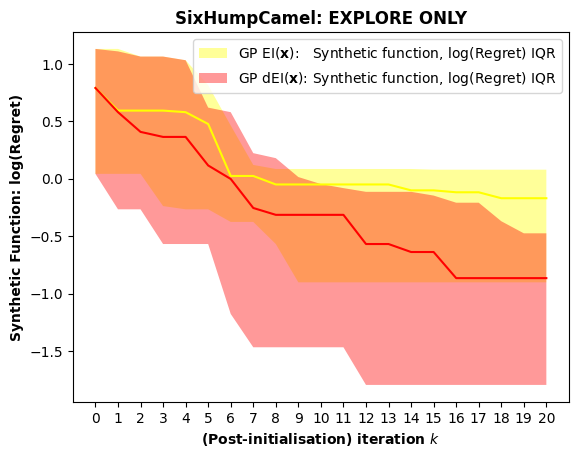

In [163]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


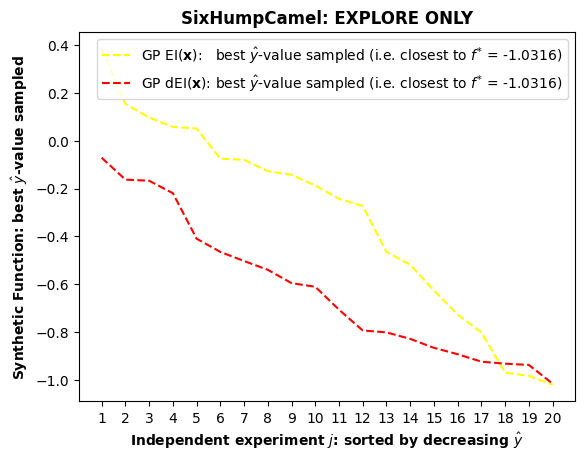

In [164]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Yellow', ls='--', label='GP EI($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = -1.0316)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Red', ls='--', label='GP dEI($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = -1.0316)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


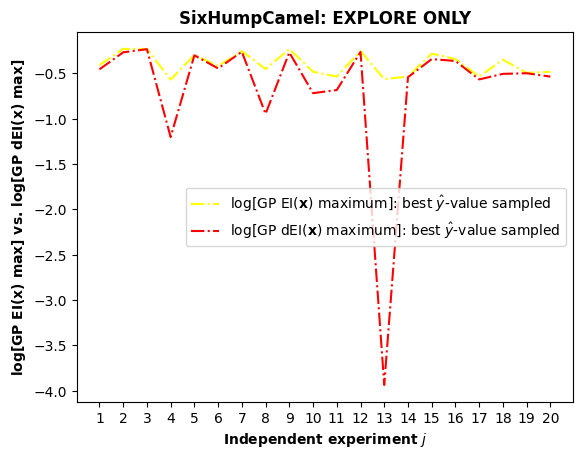

In [165]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Yellow', ls='-.', label='log[GP EI($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Red', ls='-.', label='log[GP dEI($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP EI($\mathbf{x}$) max] vs. log[GP dEI($\mathbf{x}$) max]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


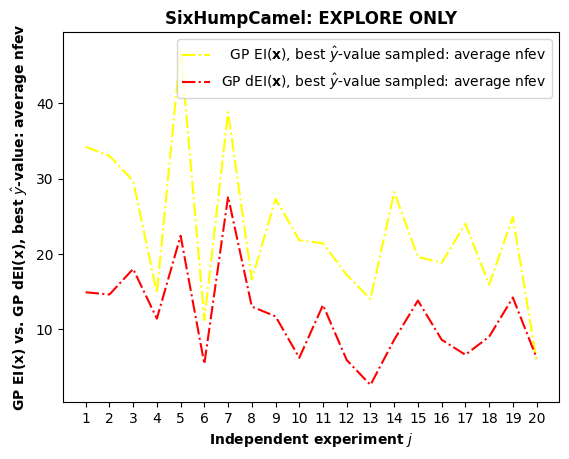

In [166]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Yellow', ls='-.', label='  GP EI($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$) vs. GP dEI($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


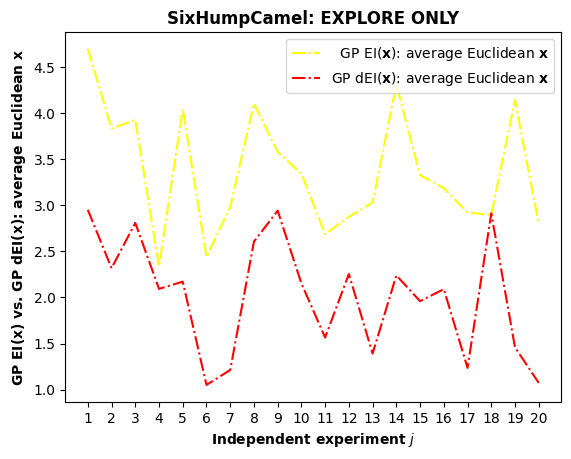

In [167]:
### Visualise!

ei_explore = ': EXPLORE ONLY'
title = obj_func + ei_explore

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Yellow', ls='-.', label='  GP EI($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$) vs. GP dEI($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([0.5657, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.5657, 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.5657, 0.5657]),
 0.5657,
 array([-0.19833216, -0.14111468]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([0.3092, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.2956, 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.0866, 0.0057]),
 0.3092,
 array([-0.50193416,  0.19192156]))

In [170]:
np.round(approx_4.x_best, 4)


array([[-0.1983, -0.1411],
       [-2.9122, -1.2587],
       [ 0.3348,  0.7084],
       [ 0.8672,  1.7902],
       [-0.8262,  1.4482],
       [ 1.5053,  0.7924],
       [ 2.0627,  1.5641],
       [ 1.1825, -1.7503],
       [-1.8611,  0.2534],
       [ 0.3301,  1.8775],
       [ 0.3943,  1.2421],
       [ 0.7868, -1.6365],
       [-0.1983, -0.1411],
       [-2.1159, -0.1364],
       [ 0.5258,  1.1893],
       [ 0.9503,  1.4026],
       [ 2.1594, -1.7423],
       [ 2.5632, -0.288 ],
       [-0.1983, -0.1411],
       [-0.1983, -0.1411]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[-0.5019,  0.1919],
       [-2.9122, -1.2587],
       [ 0.3348,  0.7084],
       [ 0.8672,  1.7902],
       [-0.8262,  1.4482],
       [ 1.5053,  0.7924],
       [ 2.0627,  1.5641],
       [ 1.1825, -1.7503],
       [-1.8611,  0.2534],
       [ 0.3301,  1.8775],
       [ 0.3943,  1.2421],
       [ 0.7868, -1.6366],
       [-0.5628,  0.1814],
       [-2.1159, -0.1364],
       [ 0.5258,  1.1893],
       [ 0.9503,  1.4026],
       [ 2.1594, -1.7423],
       [ 2.5632, -0.288 ],
       [ 0.783 , -0.843 ],
       [-0.9318,  0.2843]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


1.828916153153191

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

0.737107174049991